In [34]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import torch.nn.functional as F
import dgl
import os.path as osp
import GCL.losses as L
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam
from GCL.eval import get_split, LREvaluator, SVMEvaluator
from GCL.models import SingleBranchContrast

from scipy.io import loadmat
from GCL.models.contrast_model import WithinEmbedContrast
from dgl.nn.pytorch import GATConv, GraphConv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics


In [106]:
class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.SELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(hidden_dim, momentum=0.01)
        self.layers = nn.ModuleList()
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph):
        z = x
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = z.flatten(1)
            z = self.norm(z)
            z = self.act(z)
        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z


class Encoder(nn.Module):
    def __init__(self, graph_dict, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        gconvs = nn.ModuleDict()

        for k, v in graph_dict.items():
            if k != 'all':
                gconv = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads).to(device)
                gconvs[k] = gconv
        self.encoder = gconvs
        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5
        self.gnn = GConv(input_dim=hidden_dim, hidden_dim=hidden_dim, num_layers=1, num_heads=num_heads).to(device)
        self.pe = {}
        for key, (graph, edge_index) in graph_dict.items():
            self.pe[key] = dgl.laplacian_pe(graph, x.size(1)).to(device)

    def forward(self, x, graph_dict, edge_weight=None):
        aug1, aug2 = self.augmentor
        zs = []
        z1s = []
        z2s = []
        qs = []
        for key, (graph, edge_index) in graph_dict.items():
            if key != 'all':
                z = self.encoder[key](x + self.pe[key], graph)

                x1, edge_index1, _ = aug1(x, edge_index)
                graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
                z1 = self.encoder[key](x1, graph1)

                x2, edge_index2, _ = aug2(x, edge_index)
                graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
                z2 = self.encoder[key](x2, graph2)

                zs.append(z)
                z1s.append(z1)
                z2s.append(z2)

                # z = self.alpha * zs[0] + (1 - self.alpha) * zs[1]
                # z = zs[0]

        z = zs[0]
        # z = self.gnn(z, graph_dict['net_APCPA'][0])
        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))

        q = 1.0 / (1.0 + torch.sum(torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.v)
        q = q.pow((self.v + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()
        # qs.append(q)
        # z = self.gnn(z, graph_dict['all'][0])
        return z, z1s, z2s, q


In [36]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [37]:

device = torch.device('cuda')
path = osp.join(osp.pardir, 'datasets', 'DBLP')

mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'net_APTPA', 'label', 'train_idx', 'features', 'net_APCPA', 'net_APA', 'test_idx', 'val_idx'])


In [38]:
print(len(mat['train_idx'][0]))

800


In [39]:
# edge_index = []
# for i in tqdm(range(len(mat['PLP']))):
#     for j in range(len(mat['PLP'])):
#         if mat['PAP'][i][j] == 1:
#             edge_index.append([i, j])

graph_dict = {}
all_edge_index = []
for etype in ['net_APCPA']:
    edge_index = []
    for i in tqdm(range(len(mat[etype]))):
        for j in range(len(mat[etype])):
            if mat[etype][i][j] == 1:
                edge_index.append([i, j])
                all_edge_index.append([i, j])
    print(len(edge_index))
    edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
    graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
    graph_dict[etype] = (graph, edge_index)

all_edge_index = tensor(all_edge_index, dtype=torch.long).t().contiguous()
graph_dict['all'] = (dgl.graph((all_edge_index[0], all_edge_index[1])).to(device), all_edge_index)

100%|██████████| 4057/4057 [00:08<00:00, 467.57it/s]


5000495


In [40]:
print(graph_dict)

{'net_APCPA': (Graph(num_nodes=4057, num_edges=5000495,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 4056, 4056, 4056],
        [   0,   11,   21,  ..., 4052, 4055, 4056]])), 'all': (Graph(num_nodes=4057, num_edges=5000495,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 4056, 4056, 4056],
        [   0,   11,   21,  ..., 4052, 4055, 4056]]))}


In [41]:
x = tensor(mat['features'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)
train_idx = tensor(mat['train_idx'], dtype=torch.int64).flatten().to(device)
val_idx = tensor(mat['val_idx'], dtype=torch.int64).flatten().to(device)
test_idx = tensor(mat['test_idx'], dtype=torch.int64).flatten().to(device)
print(train_idx.size())
train_mask = torch.index_fill(torch.zeros_like(y), index=train_idx, value=1, dim=0)
val_mask = torch.index_fill(torch.zeros_like(y), index=val_idx, value=1, dim=0)
test_mask = torch.index_fill(torch.zeros_like(y), index=test_idx, value=1, dim=0)


torch.Size([800])


In [42]:
del mat


model have 93440 paramerters in total


(T): 100%|██████████| 300/300 [02:12<00:00,  2.27it/s, loss=4.72, con_loss=42.1, kl_loss=0.0509]


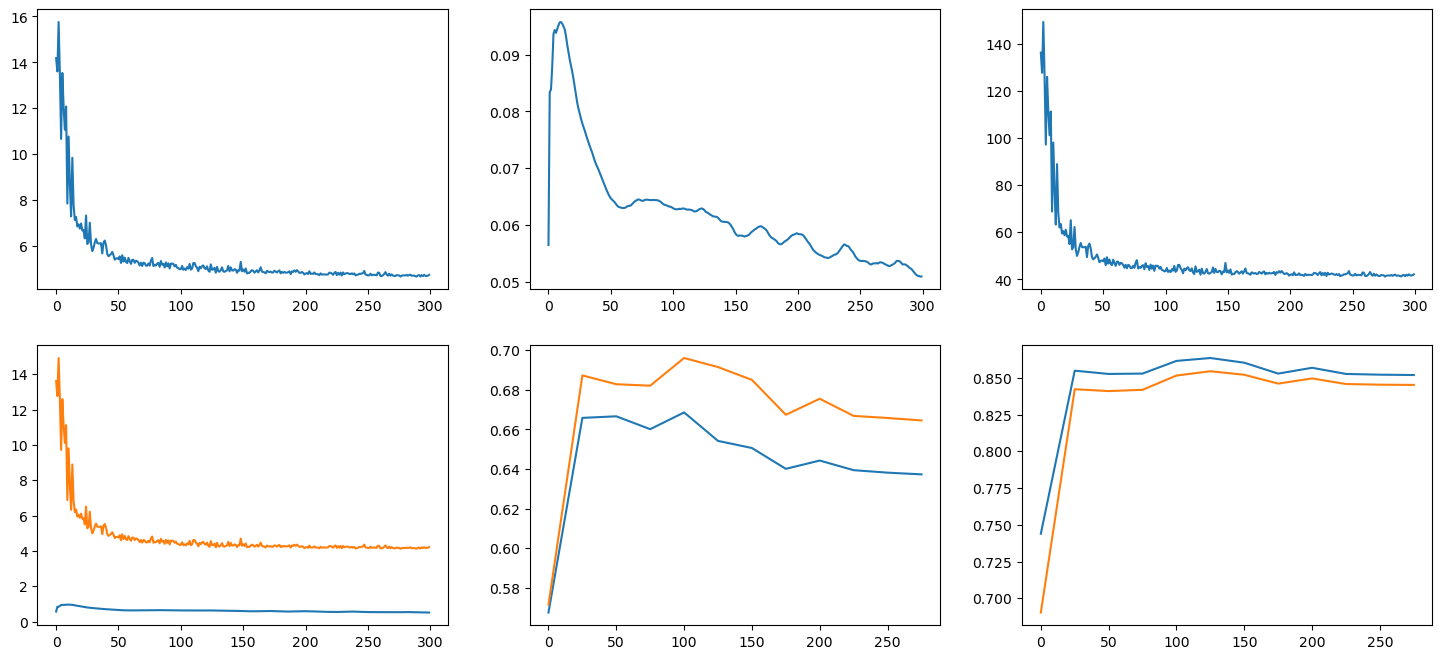

[MAX]NMI:  0.6685090204116181
[MAX]ARI:  0.6959592748041071
[MAX]ACC:  0.8634458959822529
[MAX]F1:  0.8544448041991954


In [107]:
def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro

def train(encoder_model, contrast_model, optimizer, x, graph_dict, p):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, q = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])

    kl_loss = F.kl_div(q.log(), p, reduction='batchmean')

    # con_loss = 0.01 * con_loss
    loss = (0.1 * con_loss) / len(z1s) + 10 * kl_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), kl_loss.item()


aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.5)])
aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.5)])

encoder_model = Encoder(graph_dict=graph_dict, augmentor=(aug1, aug2), hidden_dim=128, num_heads=1, n_clusters=4, num_layers=3).to(device)
print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.001, weight_decay=5e-4)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs = 300

kmeans = KMeans(n_clusters=4, n_init=20)

with torch.no_grad():
    z, _, _, _ = encoder_model(x, graph_dict)
_ = kmeans.fit_predict(z.data.cpu().numpy())
encoder_model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        if epoch % 1 == 0:
            # update_interval
            _, _, _, tmp_q = encoder_model(x, graph_dict)
            # data = 0
            # for q in tmp_q:
            #     data += q
            # data = data / len(tmp_q)
            p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph_dict, p)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _ = encoder_model(x, graph_dict)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][0].plot(range(epochs), [10 * loss for loss in kl_losss])
axes[1][0].plot(range(epochs), [0.1 * loss for loss in con_losss])
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


In [108]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, qs = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)




[INFO]NMI:  0.6372662019851606
[INFO]ARI:  0.6644756476123675


In [109]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

[INFO]NMI:  0.1197129447172589
[INFO]ARI:  0.0744662652270278


In [110]:


with torch.no_grad():
    encoder_model.eval()
    z, _, _, _ = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())
acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(acc, f1)

0.8518609810204585 0.8451413704192845
